In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats
import scipy.linalg
import scipy.signal

from rfest import get_stimulus_design_matrix
from rfest import ARD, ASD, ALD, splineLG

from sklearn.metrics import r2_score

The following script to simulate correlated noise data is ported from matlab code by [leaduncker](https://github.com/leaduncker/SimpleEvidenceOpt).

# Make 2D Receptive Field

In [2]:
dt = 1/60 # time bin size
nt = 30
nx = 40
tt = np.arange(-nt*dt, 0, dt)

kt1 = scipy.stats.gamma.pdf(-tt, 4, scale=.025)
kt2 = scipy.stats.gamma.pdf(-tt, 6, scale=.03)
kt1 /= np.linalg.norm(kt1)
kt2 /= -np.linalg.norm(kt2)

kt = np.vstack([kt1, kt2]).T

xx = np.linspace(-2, 2, nx)

kx1 = np.cos(2*np.pi*xx/2 + np.pi/5) * np.exp(-1/(2*0.35**2) * xx**2)
kx2 = np.sin(2*np.pi*xx/2 + np.pi/5) * np.exp(-1/(2*0.35**2) * xx**2)

kx1 /= np.linalg.norm(kx1)
kx2 /= np.linalg.norm(kx2)

kx = np.vstack([kx1, kx2])

k = kt @ kx
k_norm = k/np.linalg.norm(k)

Text(0.5, 1.0, 'True Receptive Field')

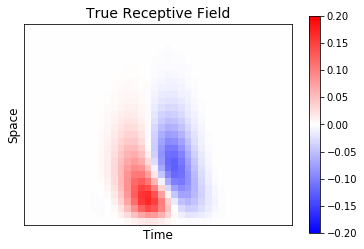

In [3]:
plt.imshow(k_norm, cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel('Time', fontsize=12)
plt.ylabel('Space', fontsize=12)
plt.title('True Receptive Field', fontsize=14)

# Simulate Correlated Noise and Response

In [4]:
N = 5000 # sample size
signse = 1 # noise stdev
Sigma = scipy.linalg.toeplitz(np.exp(-(np.arange(0, nx)) / (nx/6))) # correlated (AR1) stim covariance

mu = np.zeros(nx)
np.random.seed(2046)
Stim = np.random.multivariate_normal(mu, Sigma, N) 
X = get_stimulus_design_matrix(Stim, nt)
y = X @ k.flatten() + signse * np.random.randn(N)

dims = [nt, nx] # Receptive fields dims

# Run ASD, ALD, splineLG

In [5]:
asd = ASD(X, y, dims, compute_mle=False)
asd.fit(initial_params=np.array([1. , 1., 7., 7.,]), num_iters=10)

Iter	σ	ρ	δt	δs	cost
   0	1.010	1.010	7.010	7.010	17599.082
   1	1.020	1.018	7.017	7.019	17327.260
   2	1.030	1.025	7.024	7.028	17118.359
   3	1.040	1.025	7.033	7.027	16911.274
   4	1.050	1.024	7.040	7.026	16641.604
   5	1.060	1.023	7.048	7.026	16456.950
   6	1.070	1.023	7.056	7.026	16290.440
   7	1.079	1.021	7.062	7.024	16058.084
   8	1.089	1.022	7.069	7.024	15903.901
   9	1.099	1.023	7.075	7.024	15764.478
Stop: reached 10 steps, final cost=15764.47848.


In [6]:
ald = ALD(X, y, dims, compute_mle=False)

sigma0 = [1.]
rho0 = [1.]
params_t0 = [3., 20., 1., 1.] # taus, nus, tauf, nuf
params_y0 = [3., 20., 1., 1.]
init_params = sigma0 + rho0 + params_t0 + params_y0
ald.fit(initial_params=init_params, num_iters=10)

Iter	σ	ρ	τs_t	τf_t	τs_y	τf_y	cost
   0	1.010	1.010	3.010	1.010	2.990	1.010	8896.854
   1	1.020	1.019	3.020	1.020	2.995	1.017	8657.833
   2	1.030	1.027	3.026	1.029	2.997	1.026	8414.217
   3	1.040	1.035	3.031	1.038	2.999	1.035	8175.835
   4	1.050	1.041	3.034	1.047	2.999	1.044	7939.409
   5	1.060	1.044	3.037	1.056	3.002	1.051	7721.907
   6	1.070	1.045	3.037	1.066	3.002	1.056	7504.301
   7	1.079	1.045	3.035	1.075	3.002	1.060	7289.581
   8	1.089	1.045	3.033	1.083	3.000	1.065	7077.337
   9	1.099	1.048	3.032	1.092	3.003	1.072	6889.297
Stop: reached 10 steps, final cost=6889.29655.


In [7]:
cr = splineLG(X, y, dims=dims, df=12, smooth='cr', compute_mle=True)
cr.fit(num_iters=200, verbal=100, alpha=1, lambd=0.1)

Iter	Cost	
0	1.391	
100	1.179	
Stop: reached 200 steps, final cost=1.18036.


In [8]:
tp = splineLG(X, y, dims=dims, df=12, smooth='tp', compute_mle=True)
tp.fit(num_iters=200, verbal=100, alpha=1, lambd=0.1)

Iter	Cost	
0	432.936	
100	418.869	
Stop: reached 200 steps, final cost=405.60740.


# Plot Results

Text(0, 0.5, 'Space')

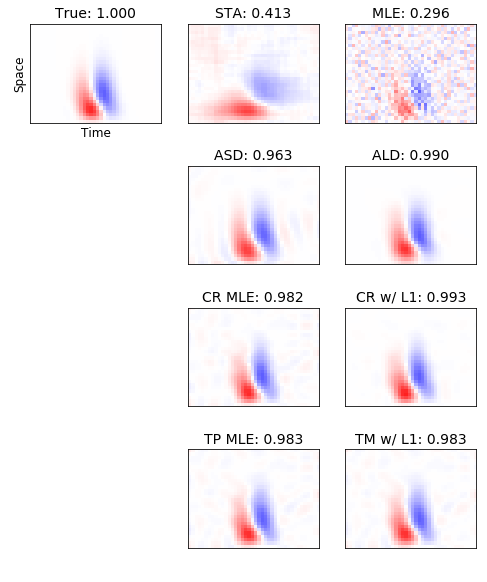

In [9]:
fig, ax = plt.subplots(4,3, figsize=(8, 10))
ax = ax.flatten()
labels = ['True', 'STA', 'MLE', '', 'ASD', 'ALD', '', 'CR MLE', 'CR w/ L1', '', 'TP MLE', 'TM w/ L1']
for ii, w in enumerate([k, cr.w_sta, cr.w_mle, 
                        0, asd.w_opt, ald.w_opt , 
                        0, cr.w_spl, cr.w_opt,
                        0, tp.w_spl, tp.w_opt]):
    
    if np.ndim(w) == 0:
        ax[ii].axis('off')
        continue
    
    w = w.reshape(dims) 
    w_norm =  w /np.linalg.norm(w)
    ax[ii].imshow(w_norm, cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
    ax[ii].set_title("{0}: {1:.3f}".format(labels[ii], r2_score(k_norm.flatten(), w_norm.flatten())), fontsize=14)
    ax[ii].set_xticks([])
    ax[ii].set_yticks([])
ax[0].set_xlabel('Time', fontsize=12)
ax[0].set_ylabel('Space', fontsize=12)

Numbers indicate the r2 score of the true RF and the retrieved RF.